In [140]:
import os
import sys
sys.path.append('/home/sensei/jupy-notebooks/Analytics/PorterFarms')
print("============================================")
print("/  CT_Profiler Switch Points is running.   /")
print("============================================")
import requests
from datetime import datetime, timedelta
import pytz
from slackclient import SlackClient
import json
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
import configparser
import time

print(os.getcwd())
config = configparser.ConfigParser()
config.read("../../analytics_secrets.ini")

_ACTIVE_STANDBY = config['DEFAULT']['role']
if _ACTIVE_STANDBY == 'STANDBY':
    print("STANDBY")
    raise SystemExit("Stop right there!")
else:
  _SLACK_TOKEN = config['slack']['token']
  _CHIRPSTACK_USER = config['chirpstack']['user']
  _CHIRPSTACK_PASS = config['chirpstack']['password']
  _DB_HOST  = config['kanjidb']['dbhost']
  _DB_PORT  = config['kanjidb']['dbport']
  _DB_NAME  = config['kanjidb']['dbname']
  _DB_USER  = config['kanjidb']['dbuser']
  _DB_PASS  = config['kanjidb']['dbpass']
    
  _LOG_DEBUG = 0
  _LOG_INFO  = 1
  _LOG_ERROR = 2
  _LOG_LEVEL = int(config['DEFAULT']['loglevel'])  
    
def logger(level, message):
    if level >= _LOG_LEVEL:
      print(message)

logger(_LOG_DEBUG, "{} {} {} {} {}".format(_DB_HOST, _DB_PORT, _DB_NAME, _DB_USER, _DB_PASS))

import kanjiticketing as kt

conn = kt.getKanjiDbConnection(_DB_HOST, _DB_PORT, _DB_NAME, _DB_USER, _DB_PASS)
if conn is not None:
  print("Welcome to Jupyter Notebook.  You are connected to the Kanji database!")
else:
  print("You are not connected to the database.")

/  CT_Profiler Switch Points is running.   /
/home/sensei/jupy-notebooks/Analytics/PorterFarms
Welcome to Jupyter Notebook.  You are connected to the Kanji database!


latest record at 2021-03-20 20:14:00-04:00
slackChannelName = general
slackChannelId   = CGNV2CUGP
latest record is 60secs old.
latest record is fresh!
       Temp is 68.3F
       Amps on 3/4 is 0.0920758928571429A
       Amps on 5/6 is 0.0A
       Amps on 7/8 is 0.0A
https://api.slack.com/img/blocks/bkb_template_images/notifications.png
Ok posting message to Slack channel
New ticket 865 created for this issue.

CT_Profiler Done!


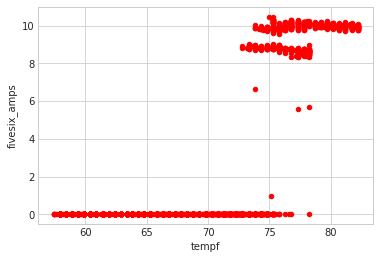

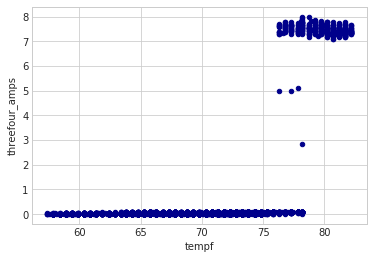

In [137]:
#_LOG_LEVEL = _LOG_DEBUG
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

_DUMP_DATA = False #True
_MAINS_FAILURE = 10011
_MAX_LATEST_RECORD_AGE_SECONDS = 300

_CT_PROFILER_MOTE = 10003
_INTERVAL_MINUTES  = 168 * 60

_MAINS_MOTE_TYPE = 10000
_BATTERY_MOTE_TYPE = 10002

now = datetime.now(pytz.utc)  #tz Aware
starttime = now - timedelta(hours=0, minutes=_INTERVAL_MINUTES)
logger(_LOG_DEBUG, "Current time is {}".format(now))
logger(_LOG_DEBUG, "Query timestamp will start at {}".format(starttime))

motequery = "SELECT node.idnode, node.name, location.description AS locname, \
             location.idlocation AS locationid, location.slackalertchannel_id AS slackchannelid \
             FROM kanji_node node JOIN kanji_location location ON node.location_id=location.idlocation \
             WHERE deploystate_id=10001 AND nodetype_id={}".format(_CT_PROFILER_MOTE)
logger(_LOG_DEBUG, motequery)
df = pd.read_sql(motequery, conn)

logger(_LOG_DEBUG, "number of motes {}".format(len(df.index)))
for ind in df.index:
    idroommote = df['idnode'][ind]
    roomName = df['locname'][ind]
    moteName = df['name'][ind]
    location_id = df['locationid'][ind]
    logger(_LOG_DEBUG, "roomnode {} room {}".format(idroommote, roomName))
    ctquery = "SELECT  date_trunc('minute', timestamp) AS timestamp, \
                       avg(bval) AS tempf, \
                       avg(cval) AS threefour_amps, avg(dval) AS fivesix_amps, avg(eval) AS seveneight_amps \
                       FROM kanji_eventlog WHERE node_id={} AND sensortype_id={} AND fcnt>0 \
                       AND timestamp>NOW() - INTERVAL '{} MINUTES' GROUP BY date_trunc('minute', timestamp) ORDER BY date_trunc('minute', timestamp) desc; ".format(idroommote, _CT_PROFILER_SENSOR_TYPE, _INTERVAL_MINUTES)
    logger(_LOG_DEBUG, ctquery)
    df1 = pd.read_sql(ctquery, conn)
    logger(_LOG_DEBUG, "number of sampling points {}".format(len(df1.index)))
    logger(_LOG_DEBUG, "ctresults df=\n{}".format(df1))
    maxtempf = 0
    mintempf = 120
    for ind in df1.index:
      time = df1['timestamp'][ind]
      amps34  = df1['threefour_amps'][ind]
      amps56  = df1['fivesix_amps'][ind]
      amps78  = df1['seveneight_amps'][ind]
      tempf = df1['tempf'][ind]
      if ind==0:
        logger(_LOG_INFO, "latest record at {}".format(time))
        age = int((now-time).total_seconds())
        locationquery = "SELECT location.idlocation, location.description, location.imageurl, \
                     slackchannel.idslackchannel, slackchannel.channelname, slackchannel.channelid, customer.slacktoken \
                     FROM kanji_location location \
                     JOIN kanji_customer customer ON location.customer_id=customer.idcustomer \
                     JOIN kanji_slackchannel slackchannel ON location.slackalertchannel_id=slackchannel.idslackchannel \
                     WHERE idlocation={}".format(location_id)
        logger(_LOG_DEBUG, locationquery)
        df3 = pd.read_sql(locationquery, conn)
        locationid = df3["idlocation"][0]
        locationdescription = df3["description"][0]
        locationimageurl = df3["imageurl"][0]
        _SLACK_TOKEN = df3["slacktoken"][0]
    
        _SLACK_CHANNEL_NAME = df3["channelname"][0]
        _SLACK_CHANNEL_ID = df3["channelid"][0]
        _SLACK_CHANNEL_DBID = df3["idslackchannel"][0]
    
        logger(_LOG_INFO, "slackChannelName = {}".format(_SLACK_CHANNEL_NAME))
        logger(_LOG_INFO, "slackChannelId   = {}".format(_SLACK_CHANNEL_ID))
        logger(_LOG_INFO, "latest record is {}secs old.".format(age))
        if (age<_MAX_LATEST_RECORD_AGE_SECONDS):
          logger(_LOG_INFO, "latest record is fresh!")
          logger(_LOG_INFO, "       Temp is {}F".format(tempf))
          logger(_LOG_INFO, "       Amps on 3/4 is {}A".format(amps34))
          logger(_LOG_INFO, "       Amps on 5/6 is {}A".format(amps56))
          logger(_LOG_INFO, "       Amps on 7/8 is {}A".format(amps78))
          #now check if fans appear to be sequencing correctly
          #room status levels are: NOMINAL, DEGRADED, HAZARDOUS, INDETERMINATE (if data is not fresh)
          _NOMINAL_AMPS_34 = 7.5
          _NOMINAL_AMPS_56 = 7.5
          _NOMINAL_AMPS_78 = 7.5
            
          _NOMINAL_THRESH_TEMPF_34      = 77
          _NOMINAL_IDLEBAND_DEGREESF_34 = 2
            
          _NOMINAL_THRESH_TEMPF_56      = 75
          _NOMINAL_IDLEBAND_DEGREESF_56 = 2
            
          _NOMINAL_THRESH_TEMPF_78      = 87
          _NOMINAL_IDLEBAND_DEGREESF_78 = 2
          
          ticketType = _MAINS_FAILURE
          description = "MAINS FAILURE DETECTED" 
          mentions = " @Charlie, @Jared"
          openTicket = kt.ticketExists(conn, idroommote, ticketType, [kt._OPEN_STATUS, kt._WORKING_STATUS])
          
          if openTicket is None:
             ticketid = kt.openticket(conn, idroommote, locationid, description, 2, 3, ticketType, _SLACK_CHANNEL_DBID)
             ts = kt.slackticket(moteName, locationdescription, description, mentions, 2, 3, locationimageurl, _SLACK_TOKEN, _SLACK_CHANNEL_NAME, ticketid, 0)
             kt.updateTicket(conn, ticketid, ts)  
             logger(_LOG_INFO, "New ticket {} created for this issue.".format(ticketid))
          else:
             logger(_LOG_INFO, "There is an existing ticket #{} for this issue. Created at {}".format(openTicket['idticket'][0], openTicket['opentimestamp'][0]))      
 
        
      if (tempf>maxtempf):
          maxtempf = tempf
      if (tempf<mintempf):
          mintempf = tempf
      if (_DUMP_DATA==True):
        if (tempf<72.0) and (amps>0.2):
          logger(_LOG_INFO, "time={} temp={} amps={}".format(time, tempf, amps56))
        logger(_LOG_INFO, "mintempf={}, maxtempf={}".format(mintempf, maxtempf))

ax1 = df1.plot.scatter(x='tempf', y='fivesix_amps', c='Red')
ax2 = df1.plot.scatter(x='tempf', y='threefour_amps', c='DarkBlue')
logger(_LOG_INFO, "\nCT_Profiler Done!")  